In [2]:
# Imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import kerastuner as kt  # Import Keras Tuner

C:\Users\pooja\AppData\Local\Temp\ipykernel_17996\2005794119.py:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt  # Import Keras Tuner


In [3]:
# Load dataset
df = pd.read_csv("final_sequential_lstm_pipeline_dataset.csv")

In [4]:
# EDA
print("Dataset Info:")
df.info()
print("\nSummary Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213831 entries, 0 to 213830
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Pipeline_ID           213831 non-null  int64  
 1   Time_Step             213831 non-null  int64  
 2   Pressure              213831 non-null  float64
 3   Temperature           213831 non-null  float64
 4   Vibration             213831 non-null  float64
 5   Corrosion_Level       213831 non-null  float64
 6   Flow_Rate             213831 non-null  float64
 7   Salinity              213831 non-null  float64
 8   Pipeline_Age          213831 non-null  float64
 9   Maintenance_History   213831 non-null  int64  
 10  Label                 213831 non-null  int64  
 11  Pressure_Temperature  213831 non-null  float64
 12  Corrosion_Flow        213831 non-null  float64
dtypes: float64(9), int64(4)
memory usage: 21.2 MB

Summary Statistics:
         Pipeline_ID   

In [5]:
# Check for null values
null_counts = df.isnull().sum()
print("Null values in each column:\n", null_counts)

Null values in each column:
 Pipeline_ID             0
Time_Step               0
Pressure                0
Temperature             0
Vibration               0
Corrosion_Level         0
Flow_Rate               0
Salinity                0
Pipeline_Age            0
Maintenance_History     0
Label                   0
Pressure_Temperature    0
Corrosion_Flow          0
dtype: int64


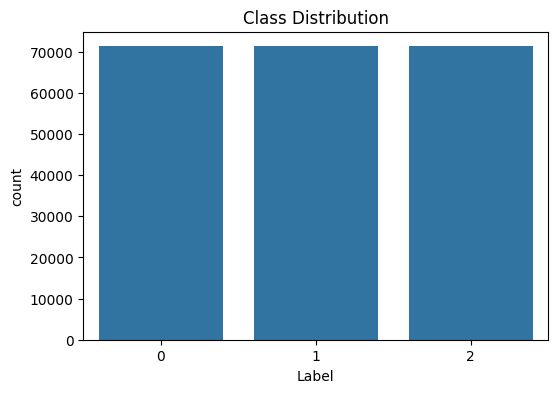

In [6]:
# Visualizing class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df['Label'])
plt.title("Class Distribution")
plt.show()

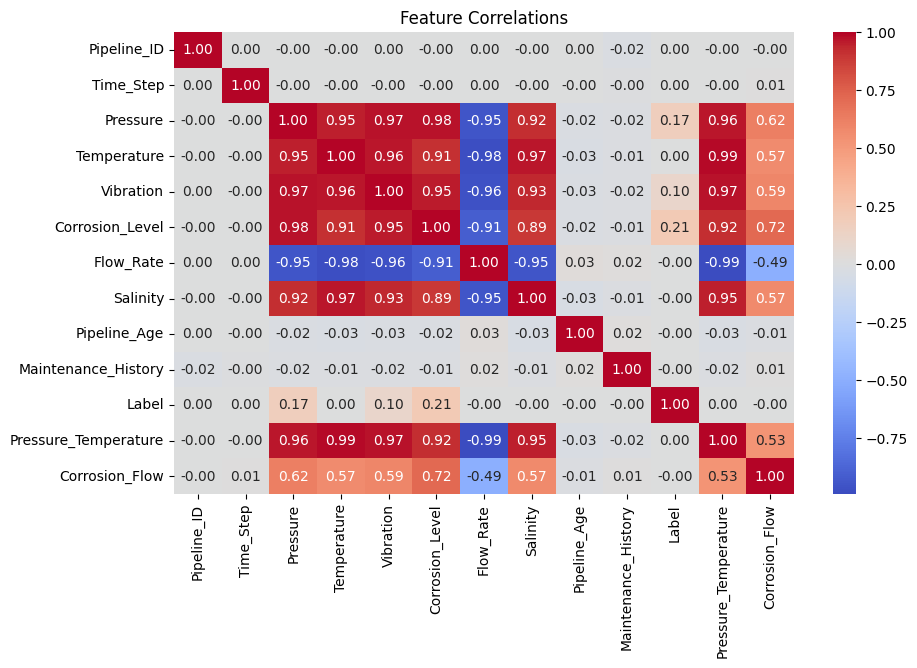

In [7]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlations")
plt.show()

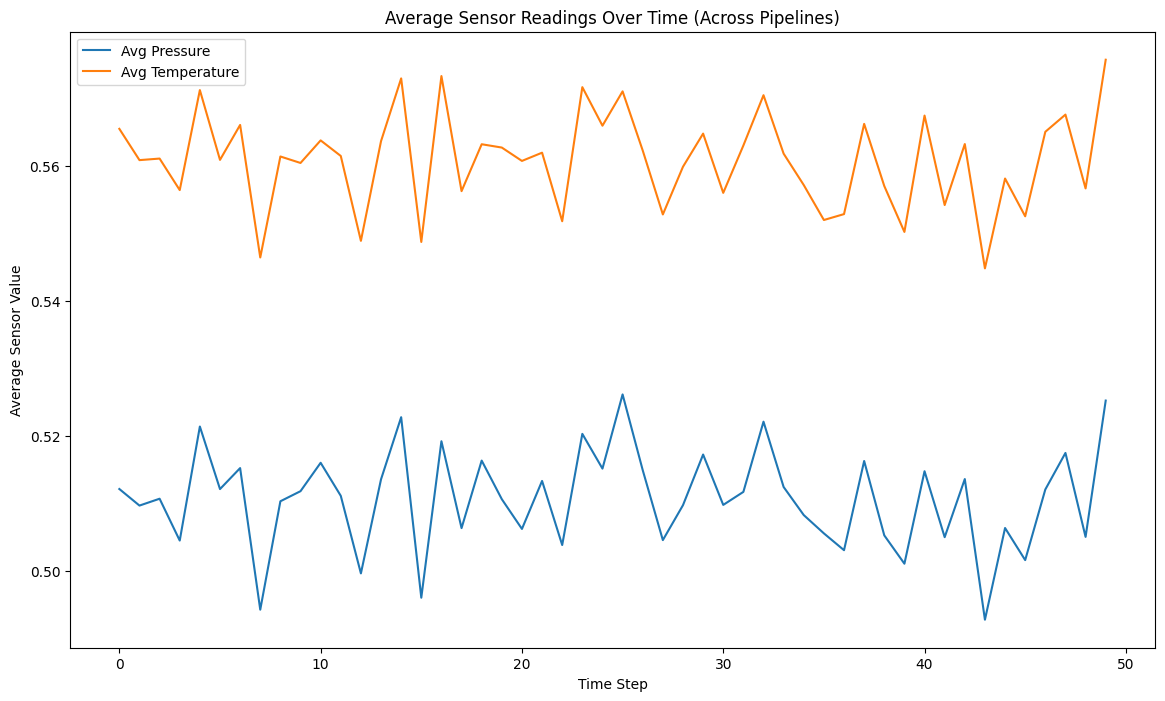

In [8]:
# 3. Aggregated Sensor Readings Over Time Across All Pipelines
# Group by Time_Step to see average sensor values across pipelines
agg_df = df.groupby('Time_Step')[['Pressure', 'Temperature']].mean().reset_index()
plt.figure(figsize=(14, 8))
plt.plot(agg_df['Time_Step'], agg_df['Pressure'], label='Avg Pressure')
plt.plot(agg_df['Time_Step'], agg_df['Temperature'], label='Avg Temperature')
plt.xlabel('Time Step')
plt.ylabel('Average Sensor Value')
plt.title('Average Sensor Readings Over Time (Across Pipelines)')
plt.legend()
plt.show()

In [9]:
# Define features and target
features = ['Pressure', 'Temperature', 'Vibration', 'Corrosion_Level',
            'Flow_Rate', 'Salinity', 'Pipeline_Age', 'Maintenance_History']
target = 'Label'

In [10]:
# Normalize features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

In [11]:
# Function to create time-series sequences
def create_sequences(data, labels, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(labels[i+seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(df[features].values, df[target].values, seq_length=10)

In [12]:
# Train/Test Split (80/20, preserving time order)
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


# --- Further split Training into Train/Validation sets ---
# For time series, it's common to take the last part of the training data for validation.
val_split_index = int(0.8 * len(X_train))
X_train_final, X_val = X_train[:val_split_index], X_train[val_split_index:]
y_train_final, y_val = y_train[:val_split_index], y_train[val_split_index:]

print("Final Training set shape:", X_train_final.shape)
print("Validation set shape:", X_val.shape)

Training set shape: (171056, 10, 8)
Testing set shape: (42765, 10, 8)
Final Training set shape: (136844, 10, 8)
Validation set shape: (34212, 10, 8)


In [13]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Example input shape (timesteps, features)
timesteps = 10
features = 8
num_classes = 3

# Build and train the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(timesteps, features), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train_final, y_train_final, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Create feature extractor (outputs from LSTM layer)


Epoch 1/10
4277/4277 [==============================] - 89s 20ms/step - loss: 0.7723 - accuracy: 0.6352 - val_loss: 0.6038 - val_accuracy: 0.7258
Epoch 2/10
4277/4277 [==============================] - 81s 19ms/step - loss: 0.5613 - accuracy: 0.7464 - val_loss: 0.5096 - val_accuracy: 0.7712
Epoch 3/10
4277/4277 [==============================] - 84s 20ms/step - loss: 0.4887 - accuracy: 0.7783 - val_loss: 0.4596 - val_accuracy: 0.7903
Epoch 4/10
4277/4277 [==============================] - 86s 20ms/step - loss: 0.4511 - accuracy: 0.7945 - val_loss: 0.4221 - val_accuracy: 0.8060
Epoch 5/10
4277/4277 [==============================] - 76s 18ms/step - loss: 0.4268 - accuracy: 0.8044 - val_loss: 0.4073 - val_accuracy: 0.8124
Epoch 6/10
4277/4277 [==============================] - 70s 16ms/step - loss: 0.4113 - accuracy: 0.8113 - val_loss: 0.4095 - val_accuracy: 0.8090
Epoch 7/10
4277/4277 [==============================] - 66s 15ms/step - loss: 0.3976 - accuracy: 0.8164 - val_loss: 0.3913 -

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18688     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 18883 (73.76 KB)
Trainable params: 18883 (73.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# Create feature extractor (outputs from LSTM layer)
feature_extractor = Model(inputs=model.inputs, outputs=model.layers[0].output)  # Access input through model.inputs
# Generate features for training and validation sets
X_train_features = feature_extractor.predict(X_train_final)
X_val_features = feature_extractor.predict(X_val)

# Ensure labels are in correct format for XGBoost
y_train_xgb = np.array(y_train_final).ravel()
y_val_xgb = np.array(y_val).ravel()

# Train XGBoost on LSTM features
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

xgb_model.fit(X_train_features, y_train_xgb)

# Evaluate XGBoost
y_pred_xgb = xgb_model.predict(X_val_features)
xgb_accuracy = accuracy_score(y_val_xgb, y_pred_xgb)
print(f"\nXGBoost validation accuracy: {xgb_accuracy:.4f}")

# Compare with LSTM's performance
lstm_loss, lstm_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Original LSTM validation accuracy: {lstm_accuracy:.4f}")

# Optional: Combine predictions (ensemble)
lstm_probs = model.predict(X_val)
xgb_probs = xgb_model.predict_proba(X_val_features)

# Average probabilities from both models
combined_probs = (lstm_probs + xgb_probs) / 2
combined_preds = np.argmax(combined_probs, axis=1)
ensemble_accuracy = accuracy_score(y_val, combined_preds)
print(f"Ensemble validation accuracy: {ensemble_accuracy:.4f}")

1070/1070 [==============================] - 6s 6ms/step


C:\Users\pooja\AppData\Roaming\Python\Python38\site-packages\xgboost\core.py:158: UserWarning: [02:37:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost validation accuracy: 0.8230
Original LSTM validation accuracy: 0.8256
1070/1070 [==============================] - 11s 9ms/step
Ensemble validation accuracy: 0.8262


In [16]:
from tensorflow.keras.models import load_model
# After training
model.save("lstm_model.h5")

C:\Users\pooja\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
